# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [183]:
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV

In [184]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<H2>Dataset Introduction</H2>

For this first part, we will familiarize ourselves with the three datasets for the Starbucks customer data and profiles, in an effort to understand what we are working with.

In [185]:
# obtain the dimensions of the Starbucks customer portfolio dataset
portfolio.shape

(10, 6)

In [186]:
# Print out the entire portfolio (since this is a small dataset)
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [187]:
# Obtain the data types for the portfolio
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [188]:
# Define a function that will create a horizontal bar graph
def plot_barh(df, column, title, bInvertYAxis=True):
    plt.figure(figsize=(8,8))
    plt.style.use("seaborn-pastel")
    fig, ax = plt.subplots()    
    y_counts = df[column].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
        y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=12, fontweight='bold')
        plt.title(title)

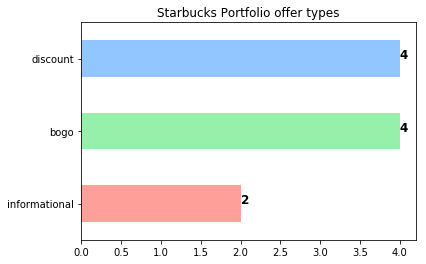

In [189]:
# Plot the bar graph
plot_barh(portfolio, 'offer_type', 'Starbucks Portfolio offer types')

In [190]:
# obtain the dimensions of the Starbucks customer profile dataset
profile.shape

(17000, 5)

In [191]:
# print out the first ten rows of the profile dataset
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [192]:
# check missing values in profile
profile.isna().sum(axis=0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [193]:
# Obtain the data types for the profile
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [194]:
# obtain the dimensions of the Starbucks customer transcript dataset
transcript.shape

(306534, 4)

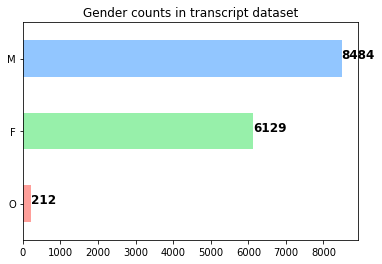

In [195]:
# Plot the bar graph for gender
plot_barh(profile, 'gender', "Gender counts in transcript dataset")

In [196]:
# print out the first ten rows of the transcript dataset
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [197]:
# Obtain the data types for the transcript
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [198]:
# check missing values in transcript
transcript.isna().sum(axis=0)

event     0
person    0
time      0
value     0
dtype: int64

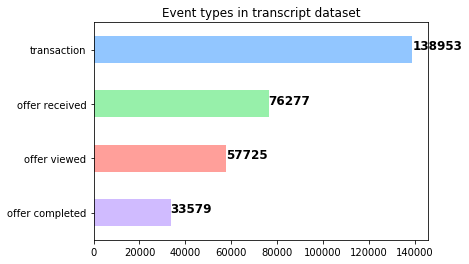

In [199]:
plot_barh(transcript, 'event', "Event types in transcript dataset")

<H2>Data Cleaning</H2>

<P>For the data cleaning, we will clean the datasets for both profile and transcript.</P>

In [200]:
# Convert format of became_member_on from YYYYMMDD to YYYY-MM-DD
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [201]:
# Remove those profiles that match the age of 118
remove  = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)

In [202]:
# store 0 and 1s in new columns
profile['missing'] = profile['age'].apply(lambda val: 1 if pd.isna(val) else 0)
dropped = profile[profile['missing'] == 1].index

In [203]:
# Store profile in new cleaned dataset
cust_profile = profile.drop(dropped)

In [204]:
# Print out first 10 rows of new profile dataset
cust_profile.head(10)

,age,became_member_on,gender,id,income,missing
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0
5,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,0
6,26,2014-02-13,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,0
7,62,2016-02-11,F,31dda685af34476cad5bc968bdb01c53,71000.0,0
8,49,2014-11-13,M,62cf5e10845442329191fc246e7bcea3,52000.0,0
9,57,2017-12-31,M,6445de3b47274c759400cd68131d91b4,42000.0,0


In [205]:
# Process to build a new dataframe that consists of transaction, offer received,
# offer viewed, offer completed
the_transaction = transcript[transcript.event == 'transaction']
the_offer_received = transcript[transcript.event == 'offer received']
the_offer_viewed = transcript[transcript.event == 'offer viewed']
the_offer_completed = transcript[transcript.event == 'offer completed']

In [206]:
the_transaction['amount'] = the_transaction.value.apply(lambda x:list(x.values())[0])
the_offer_received['offer_id'] = the_offer_received.value.apply(lambda x:list(x.values())[0])
the_offer_viewed['offer_id'] = the_offer_viewed.value.apply(lambda x:list(x.values())[0])
the_offer_completed['offer_id'] = the_offer_completed.value.apply(lambda x:list(x.values())[0])
the_offer_completed['reward'] = the_offer_completed.value.apply(lambda x:list(x.values())[1])

In [207]:
# Creating the new dataframe
transcript = pd.concat([the_transaction, the_offer_received, the_offer_viewed, the_offer_completed])
transcript = transcript[['event', 'person', 'offer_id', 'time', 'amount', 'reward', 'value']]
transcript.drop(columns='value', inplace=True)

In [208]:
# Print out first ten rows of new dataframe
transcript.head(10)

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN
12678,transaction,629fc02d56414d91bca360decdfa9288,NaN,0,33.90,NaN
12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,NaN,0,0.22,NaN
12687,transaction,a97e6f33219c432db82acfa0d19c602d,NaN,0,18.59,NaN
12691,transaction,676506bad68e4161b9bbaffeb039626b,NaN,0,18.01,NaN
12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,NaN,0,19.11,NaN


In [209]:
# Get dimensions of the new dataframe
transcript.shape

(306534, 6)

<H2>Data Analysis</H2>

Text(0,0.5,'Number of customers')

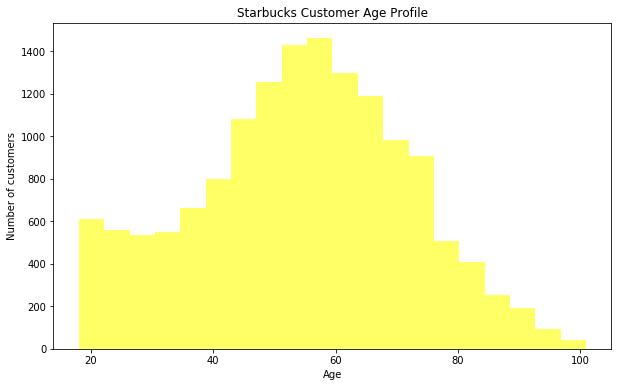

In [210]:
# Create a histogram showing the ages for all customers in the profile dataset
plt.figure(figsize=(10,6))
plt.hist(cust_profile['age'], bins=20, color='#FFFF66')
plt.title('Starbucks Customer Age Profile')
plt.xlabel('Age')
plt.ylabel('Number of customers')

<P>According to the above histogram, the majority of customers are between 50 to 60 years of age.</P>

Text(0,0.5,'Number of customers')

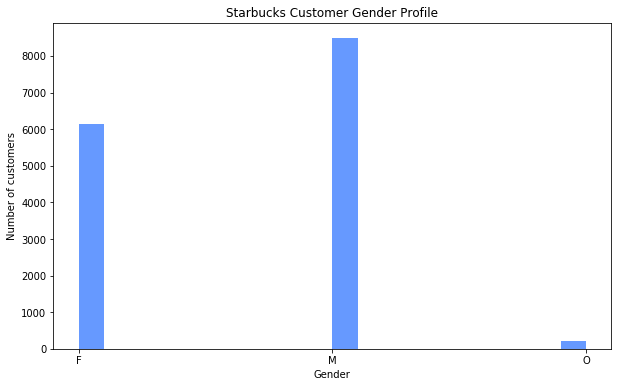

In [211]:
# Create a histogram showing the genders for all customers in the profile dataset
plt.figure(figsize=(10,6))
plt.hist(cust_profile['gender'], bins=20, color='#6699FF')
plt.title('Starbucks Customer Gender Profile')
plt.xlabel('Gender')
plt.ylabel('Number of customers')

<P>According to the above histogram, the majority of customers are male.</P>

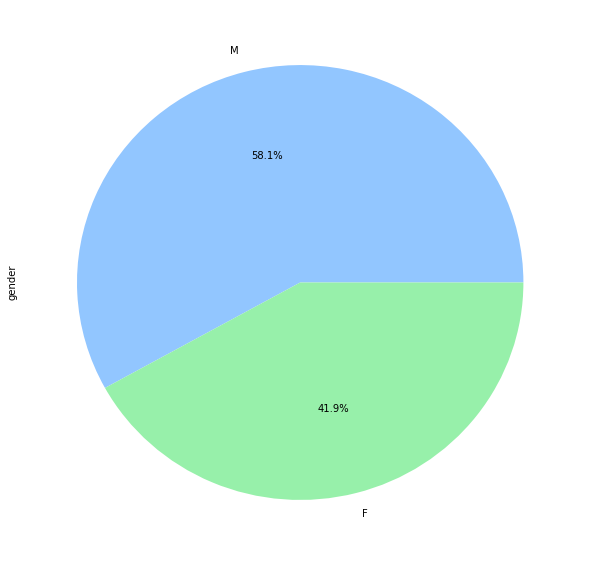

In [212]:
# Create a pie chart for all genders in the dataset
gender_pie_chart = cust_profile[cust_profile['gender'] != 'O']
gender_pie_chart.gender.value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

<P>According to the pie chart above, 58% of the customers are male and 42% are female; less than 1% identify as gender 'O'</P>

Text(0,0.5,'Number of customers')

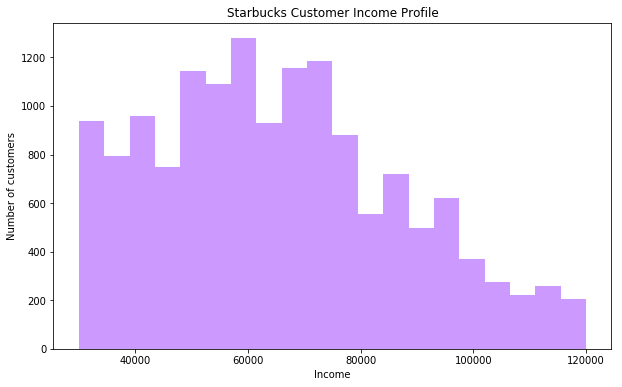

In [213]:
# Create a histogram showing the incomes for all customers in the profile dataset
plt.figure(figsize=(10,6))
plt.hist(cust_profile['income'], bins=20, color='#CC99FF')
plt.title('Starbucks Customer Income Profile')
plt.xlabel('Income')
plt.ylabel('Number of customers')

<P>According to the above histogram, the majority of customers' annual income is between 50K to 70K (but higher more towards 70K).</P>

In [214]:
# Print out the summary of the above histograms, to obtain a customer profile
print("Summary of Starbucks customer profile")
print("----------------------------------")
print("Age: ", cust_profile.age.mean())
print("Gender:  M")
print("Income: ", cust_profile.income.mean())

Summary of Starbucks customer profile
----------------------------------
Age:  54.3935244519
Gender:  M
Income:  65404.9915683


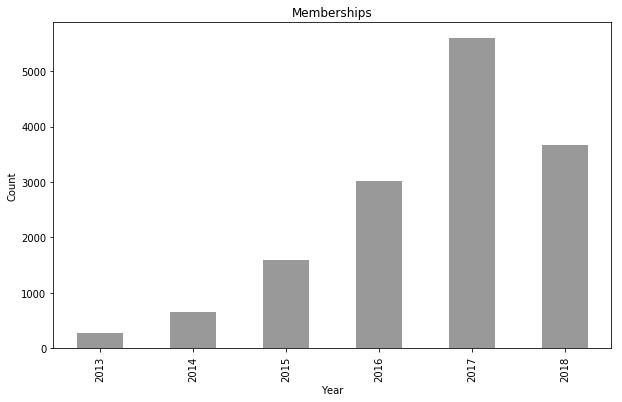

In [215]:
# Create a bar graph showing the memberships for all customers in the profile dataset
# versus the years in which customers became a member
plt.figure(figsize=(10,6))
cust_profile['membership_year'] = profile['became_member_on'].dt.year
membership = cust_profile.groupby('membership_year').count()['id']
membership.plot(kind='bar', color='#999999')
plt.title('Memberships')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

<P>The year in which memberships was highest was in 2017.</P>

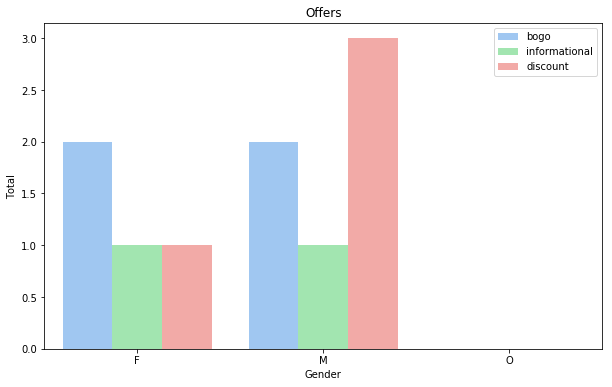

In [216]:
# Display the list of offers between the genders
plt.figure(figsize=(10,6))
plt.style.use("seaborn-pastel")
sns.countplot(x=cust_profile.gender, hue=portfolio.offer_type)
plt.title('Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.legend(loc='upper right')
plt.show();

<P>According to the above graph, the most popular Starbucks offer for female customers is BOGO; for male customers, however, it is the traditional discount offer (but BOGO is just as popular with male customers as it is for female customers).</P>

<H2>Data Preparation</H2>

In [217]:
# First we will get the event data to convert into dummy values, then we will remove
# duplicate rows from the transcript dataframe
transcript = pd.get_dummies(transcript, columns=['event'] , prefix='', prefix_sep='')
transcript.drop_duplicates(inplace=True)

In [218]:
# Created a merged dataset that includes individual (person), 
# Also replace any 'NaN' values with 0
merge_data = pd.merge(transcript, profile, left_on='person', right_on='id', how='inner')
merge_data.drop(columns=['id'], inplace=True)
merge_data.reward.fillna(0, inplace=True)
merge_data.amount.fillna(0, inplace=True)

In [219]:
# sort values
merge_data.sort_values(by=['time'], ascending=True, inplace=True)
list1 = ['transaction', 'amount']
for i in list1:
    merge_data[i] = merge_data.groupby('person')[i].cumsum()

In [220]:
merge_data.dropna(subset=['offer_id'], inplace=True)

In [221]:
merge_data = merge_data.merge(portfolio, left_on='offer_id', right_on='id', how='left')

In [222]:
# Obtain the first ten rows of the merged dataset
merge_data.head(10)

,person,offer_id,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,missing,channels,difficulty,duration,id,offer_type,reward_y
0,a5c24057de1147a798422162559bbe83,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0.0,0.0,0,1,0,0,33,2018-06-12,M,45000.0,0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
1,84eb11751c674c5ab910f3bebe78586d,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.0,0.0,0,1,0,0,73,2013-11-15,M,63000.0,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
2,8dc17515545e42d9a2974a3aebc3aa69,fafdcd668e3743c1bb461111dcafc2a4,0,0.0,0.0,0,1,0,0,61,2018-06-08,M,43000.0,0,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
3,a5675e02cac04aefb87d21551a3dfa8c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,0.0,0,1,0,0,42,2017-11-20,M,54000.0,0,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,3339d9d8f5ff4664bd259572330c5dbf,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,1,0,0,62,2014-11-05,M,44000.0,0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
5,b5b17db2d0af49fe89abfd7076b605a8,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0.0,0.0,0,1,0,0,58,2017-02-26,M,39000.0,0,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,60ae06998f034851b0c571f8fb4e1165,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0.0,0.0,0,1,0,0,55,2017-12-17,M,62000.0,0,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
7,a5c24057de1147a798422162559bbe83,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0.0,10.0,1,0,0,0,33,2018-06-12,M,45000.0,0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
8,ba1ae0413fee458f99c7f5cc13e99021,5a8bc65990b245e5a138643cd4eb9837,0,0.0,0.0,0,1,0,0,34,2018-01-16,M,50000.0,0,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
9,ca265792e65949d79b2b0e91bdd31c57,fafdcd668e3743c1bb461111dcafc2a4,0,0.0,0.0,0,1,0,0,34,2017-07-22,F,37000.0,0,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2


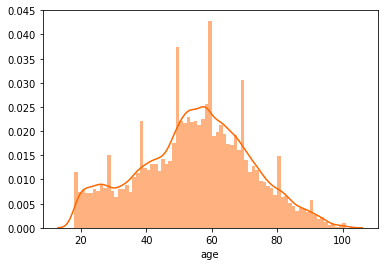

In [223]:
sns.distplot(merge_data['age'], color="#FF6600", bins=75, hist_kws={'alpha': 0.5});

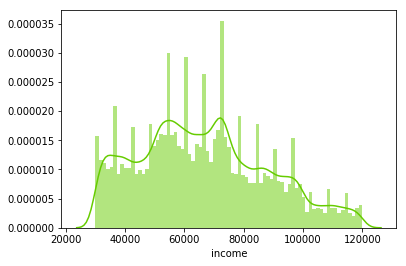

In [224]:
sns.distplot(merge_data['income'], color="#66CC00", bins=75, hist_kws={'alpha': 0.5});

In [225]:
# Print out the summary of the above sns distribution plots
print("Summary of Starbucks customer profile")
print("----------------------------------")
print("Age: ", merge_data.age.mean())
print("Gender:  M")
print("Income: ", merge_data.income.mean())

Summary of Starbucks customer profile
----------------------------------
Age:  54.7777351092
Gender:  M
Income:  66403.1165996


In [226]:
prep_data = merge_data.groupby(['person', 'offer_type']).agg(
    {
        'offer completed': sum, 
        'offer received': sum,
        'offer viewed': sum,
        'age': 'last',
        'became_member_on': 'last',
        'gender': 'last',
        'income': 'last'
    }
).reset_index()

In [227]:
def trans_offer(df):
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0

    for index, row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index, 'bogo_completed'] = row['offer completed']
            df.loc[index, 'bogo_received'] = row['offer received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index, 'discount_completed'] = row['offer completed']
            df.loc[index, 'discount_received'] = row['offer received']
        
    return df.groupby(['person']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum,        
    }
).reset_index()

In [228]:
trans_data = trans_offer(prep_data)

In [229]:
trans_data.head(10)

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3
5,00426fe3ffde4c6b9cb9ad6d077a13ea,19,2016-08-09,F,65000.0,0,0,4,1
6,004b041fbfe44859945daa2c7f79ee64,55,2018-05-08,F,74000.0,1,1,1,1
7,004c5799adbf42868b9cff0396190900,54,2016-03-31,M,99000.0,3,3,2,2
8,005500a7188546ff8a767329a2f7c76a,56,2017-12-09,M,47000.0,4,1,1,0
9,0056df74b63b4298809f0b375a304cf4,54,2016-08-21,M,91000.0,1,1,2,2


In [230]:
# create colunms with the percentage of each offer
trans_data['bogo_percentage'] = trans_data.bogo_completed.div(trans_data.bogo_received.where(trans_data.bogo_received != 0, np.nan))*100
trans_data['discount_percentage'] = trans_data.discount_completed.div(trans_data.discount_received.where(trans_data.discount_received != 0, np.nan))*100

In [231]:
trans_data.fillna(0, inplace=True)

In [232]:
trans_data.isna().sum()

person                 0
age                    0
became_member_on       0
gender                 0
income                 0
bogo_received          0
bogo_completed         0
discount_received      0
discount_completed     0
bogo_percentage        0
discount_percentage    0
dtype: int64

In [233]:
trans_data['bogo_offer'] = 0
trans_data['discount_offer'] = 0

for i, row in trans_data.iterrows():

    if(row['bogo_percentage'] >= 80):
        trans_data.loc[i, 'bogo_offer'] = 1
        
    if(row['discount_percentage'] >= 80):
        trans_data.loc[i, 'discount_offer'] = 1

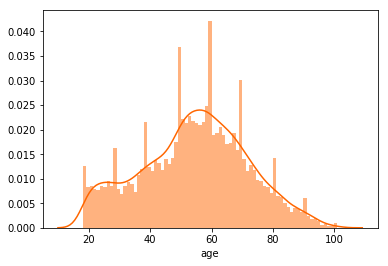

In [234]:
sns.distplot(trans_data['age'], color="#FF6600", bins=75, hist_kws={'alpha': 0.5});

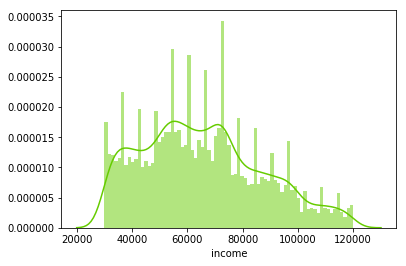

In [235]:
sns.distplot(trans_data['income'], color="#66CC00", bins=75, hist_kws={'alpha': 0.5});

In [236]:
# Print out the summary of the above sns distribution plots
print("Summary of Starbucks customer profile")
print("----------------------------------")
print("Age: ", trans_data.age.mean())
print("Gender:  M")
print("Income: ", trans_data.income.mean())

Summary of Starbucks customer profile
----------------------------------
Age:  54.3890688259
Gender:  M
Income:  65406.8825911


<P>The customer data is mostly unchanged from what it was previously.  The age is the same, but the income was 66403 in the merged data, versus 65406 in the trans data.</P>

<H2>Data Modeling</H2>

In [237]:
model_data = trans_data.copy()
model_data['year'] = model_data.became_member_on.dt.year
model_data['month'] = model_data.became_member_on.dt.month

In [238]:
model_data = model_data[['age', 'gender', 'income', 'year', 'month', 'discount_offer', 'bogo_offer']]

In [239]:
dummy_data = pd.get_dummies(model_data, columns=['gender'])

In [240]:
x = dummy_data.drop(columns=['discount_offer' ,'bogo_offer'])
y_bogo = dummy_data.bogo_offer
y_discount = dummy_data.discount_offer

In [241]:
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(x, y_bogo, random_state=50)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 11115 rows
Testing set: 3705 rows


In [242]:
X_train, X_test, y_discount_train, y_discount_test = train_test_split(x, y_discount, random_state=50)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 11115 rows
Testing set: 3705 rows


In [243]:
# KNearestNeighbor Classifier
knn_bogo = KNeighborsClassifier(n_neighbors = 5)
knn_discount = KNeighborsClassifier(n_neighbors = 5)
knn_bogo.fit(X_train, y_bogo_train)
knn_discount.fit(X_train, y_discount_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [244]:
# Setting up the K-Nearest Neighbors values for Train and Test
knn_bogo_score_train = round((knn_bogo.score(X_train, y_discount_train)), 4)
knn_bogo_score_test = round((knn_bogo.score(X_test, y_discount_test)), 4)
knn_discount_score_train = round((knn_discount.score(X_train, y_discount_train)), 4)
knn_discount_score_test = round((knn_discount.score(X_test, y_discount_test)), 4)

knn = { 'BOGO Train F1':[knn_bogo_score_train],
        'BOGO Test F1':[knn_bogo_score_test],
        'Discount Train F1':[knn_discount_score_train],
        'Discount Test F1':[knn_discount_score_test]
      }

KNNSummary = pd.DataFrame(knn)

In [245]:
# Display the results for K-Nearest Neighbors
KNNSummary

,BOGO Train F1,BOGO Test F1,Discount Train F1,Discount Test F1
0,0.5919,0.549,0.7133,0.5314


In [246]:
# GaussianNB Classifier
gauss_bogo = GaussianNB()
gauss_discount = GaussianNB()
gauss_bogo.fit(X_train, y_bogo_train)
gauss_discount.fit(X_train, y_discount_train)

GaussianNB(priors=None)

In [247]:
# Setting up the Gaussian NB values for Train and Test
gauss_bogo_score_train = round((gauss_bogo.score(X_train, y_discount_train)), 4)
gauss_bogo_score_test = round((gauss_bogo.score(X_test, y_discount_test)), 4)
gauss_discount_score_train = round((gauss_discount.score(X_train, y_discount_train)), 4)
gauss_discount_score_test = round((gauss_discount.score(X_test, y_discount_test)), 4)

gauss = { 'BOGO Train F1':[gauss_bogo_score_train],
          'BOGO Test F1':[gauss_bogo_score_test],
          'Discount Train F1':[gauss_discount_score_train],
          'Discount Test F1':[gauss_discount_score_test]
      }

gaussSummary = pd.DataFrame(gauss)

In [248]:
# Display the results for Gaussian NB
gaussSummary

,BOGO Train F1,BOGO Test F1,Discount Train F1,Discount Test F1
0,0.5973,0.6057,0.6167,0.6227


In [249]:
# Support Vector Machine Classifier
svc_bogo = SVC()
svc_discount = SVC()
svc_bogo.fit(X_train, y_bogo_train)
svc_discount.fit(X_train, y_discount_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [250]:
# Setting up the Support Vector values for Train and Test
svc_bogo_score_train = round((svc_bogo.score(X_train, y_discount_train)), 4)
svc_bogo_score_test = round((svc_bogo.score(X_test, y_discount_test)), 4)
svc_discount_score_train = round((svc_discount.score(X_train, y_discount_train)), 4)
svc_discount_score_test = round((svc_discount.score(X_test, y_discount_test)), 4)

svc = { 'BOGO Train F1':[svc_bogo_score_train],
        'BOGO Test F1':[svc_bogo_score_test],
        'Discount Train F1':[svc_discount_score_train],
        'Discount Test F1':[svc_discount_score_test]
      }
svcSummary = pd.DataFrame(svc)

In [251]:
# Display the results for Support Vector
svcSummary

,BOGO Train F1,BOGO Test F1,Discount Train F1,Discount Test F1
0,0.6301,0.5511,0.8956,0.5363


In [252]:
# Ada Boost Classifier
ada_bogo = AdaBoostClassifier()
ada_discount = AdaBoostClassifier()
ada_bogo.fit(X_train, y_bogo_train)
ada_discount.fit(X_train, y_discount_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [253]:
# Setting up the AdaBoost values for Train and Test
ada_bogo_score_train = round((ada_bogo.score(X_train, y_discount_train)), 4)
ada_bogo_score_test = round((ada_bogo.score(X_test, y_discount_test)), 4)
ada_discount_score_train = round((ada_discount.score(X_train, y_discount_train)), 4)
ada_discount_score_test = round((ada_discount.score(X_test, y_discount_test)), 4)

ada = { 'BOGO Train F1':[ada_bogo_score_train],
        'BOGO Test F1':[ada_bogo_score_test],
        'Discount Train F1':[ada_discount_score_train],
        'Discount Test F1':[ada_discount_score_test]
      }
adaSummary = pd.DataFrame(ada)

In [254]:
# Display the AdaBoost results
adaSummary

,BOGO Train F1,BOGO Test F1,Discount Train F1,Discount Test F1
0,0.6366,0.6394,0.658,0.6462


In [255]:
# Random Forest Classifier
rfc_bogo = RandomForestClassifier(random_state = 10)
rfc_discount = RandomForestClassifier(random_state = 10)
rfc_bogo.fit(X_train, y_bogo_train)
rfc_discount.fit(X_train, y_discount_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [256]:
# Setting up the Random Forest values for Train and Test
rfc_bogo_score_train = round((rfc_bogo.score(X_train, y_discount_train)), 4)
rfc_bogo_score_test = round((rfc_bogo.score(X_test, y_discount_test)), 4)
rfc_discount_score_train = round((rfc_discount.score(X_train, y_discount_train)), 4)
rfc_discount_score_test = round((rfc_discount.score(X_test, y_discount_test)), 4)

rfc = { 'BOGO Train F1':[rfc_bogo_score_train],
        'BOGO Test F1':[rfc_bogo_score_test],
        'Discount Train F1':[rfc_discount_score_train],
        'Discount Test F1':[rfc_discount_score_test]
      }
rfcSummary = pd.DataFrame(rfc)

In [257]:
# Display the Random Forest results
rfcSummary

,BOGO Train F1,BOGO Test F1,Discount Train F1,Discount Test F1
0,0.6582,0.6062,0.9655,0.6016


In [258]:
# Decision Tree Classifier
dtc_bogo = DecisionTreeClassifier(random_state = 10)
dtc_discount = DecisionTreeClassifier(random_state = 10)
dtc_bogo.fit(X_train, y_bogo_train)
dtc_discount.fit(X_train, y_discount_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [259]:
# Setting up the Decision Tree values for Train and Test
dtc_bogo_score_train = round((dtc_bogo.score(X_train, y_discount_train)), 4)
dtc_bogo_score_test = round((dtc_bogo.score(X_test, y_discount_test)), 4)
dtc_discount_score_train = round((dtc_discount.score(X_train, y_discount_train)), 4)
dtc_discount_score_test = round((dtc_discount.score(X_test, y_discount_test)), 4)

dtc = { 'BOGO Train F1':[dtc_bogo_score_train],
        'BOGO Test F1':[dtc_bogo_score_test],
        'Discount Train F1':[dtc_discount_score_train],
        'Discount Test F1':[dtc_discount_score_test]
      }
dtcSummary = pd.DataFrame(dtc)

In [260]:
# Display the Decision Tree results
dtcSummary

,BOGO Train F1,BOGO Test F1,Discount Train F1,Discount Test F1
0,0.6627,0.5695,0.9913,0.5727


In [261]:
# Create a summary of the Train and Test data for BOGO
bogo_classifier = ['K-Nearest Neighbors',
                   'Gaussian NB',
                   'Support Vector',
                   'AdaBoost',
                   'Random Forest',
                   'Decision Tree']

bogo_data_train = [knn_bogo_score_train, gauss_bogo_score_train, svc_bogo_score_train, ada_bogo_score_train,
                   rfc_bogo_score_train, dtc_bogo_score_train]
bogo_data_test = [knn_bogo_score_test, gauss_bogo_score_test, svc_bogo_score_test, ada_bogo_score_test,
                  rfc_bogo_score_test, dtc_bogo_score_test]

# Define the BOGO dataframe
bogo_summary = pd.DataFrame({'Model': bogo_classifier,
                             'Train F1': bogo_data_train,
                             'Test F1': bogo_data_test})

# Print the BOGO dataframe
bogo_summary

,Model,Train F1,Test F1
0,K-Nearest Neighbors,0.5919,0.5490
1,Gaussian NB,0.5973,0.6057
2,Support Vector,0.6301,0.5511
3,AdaBoost,0.6366,0.6394
4,Random Forest,0.6582,0.6062
5,Decision Tree,0.6627,0.5695


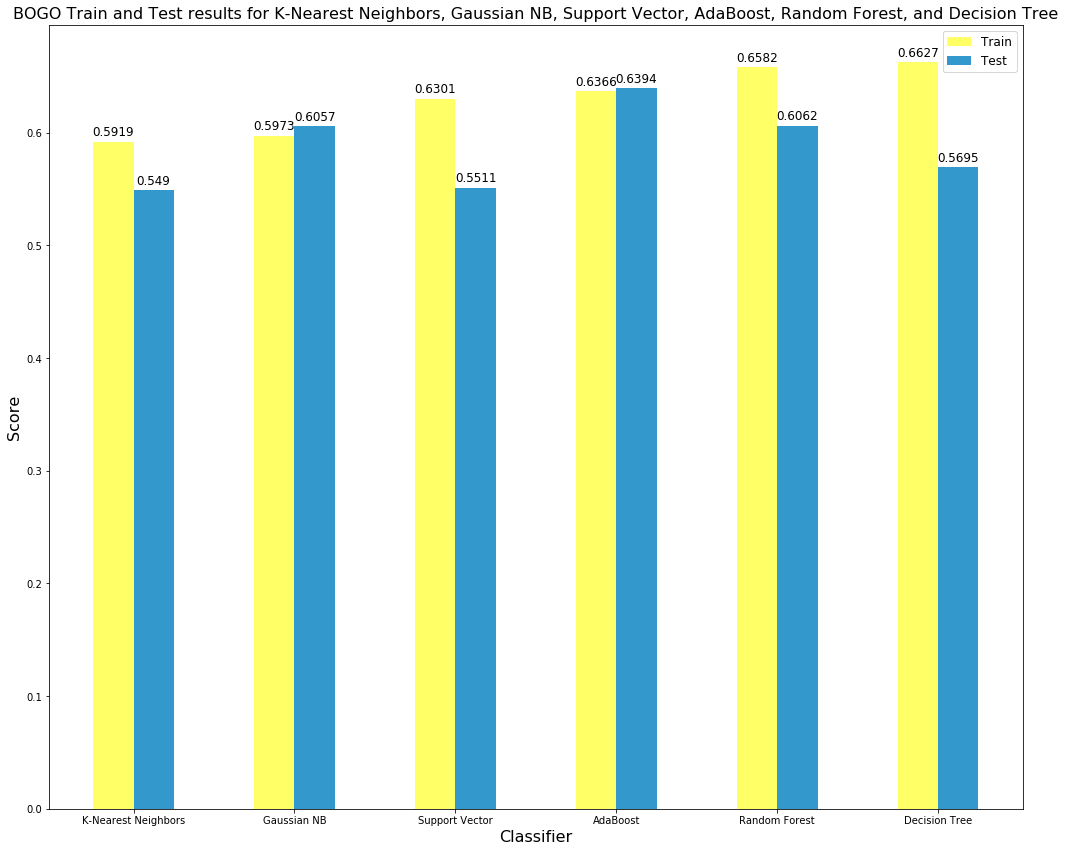

In [262]:
# This code plots the graph for the BOGO classifier model values for  K-Nearest Neighbors, Gaussian NB,
# Support Vector, AdaBoost, Random Forest, and Decision Tree

x1_pos = np.arange(len(bogo_classifier))
width = 0.25

fig, ax = plt.subplots()
bogo_train_rects = ax.bar(x1_pos - width/2, bogo_data_train, width, color='#FFFF66', label='Train')
bogo_test_rects = ax.bar(x1_pos + width/2, bogo_data_test, width, color='#3399CC', label='Test')

ax.set_title('BOGO Train and Test results for K-Nearest Neighbors, Gaussian NB, Support Vector, AdaBoost, Random Forest, and Decision Tree', fontsize=16)
ax.set_ylabel('Score', fontsize=16)
ax.set_xlabel('Classifier', fontsize=16)

ax.set_xticks(x1_pos)
ax.set_xticklabels(bogo_classifier)
fig.set_size_inches(16.0, 12.0)
plt.rcParams.update({'font.size': 12})
ax.legend()

# Function to generate labels on top of the bars
def gen_label(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Generate the labels
gen_label(bogo_train_rects)
gen_label(bogo_test_rects)

fig.tight_layout()

plt.show()

In [263]:
# Create a summary of the Train and Test data for Discount
discount_classifier = ['K-Nearest Neighbors',
                       'Gaussian NB',
                       'Support Vector',
                       'AdaBoost',
                       'Random Forest',
                       'Decision Tree']

discount_data_train = [knn_discount_score_train, gauss_discount_score_train, svc_discount_score_train,
                       ada_discount_score_train, rfc_discount_score_train, dtc_discount_score_train]
discount_data_test = [knn_discount_score_test, gauss_discount_score_test, svc_discount_score_test,
                      ada_discount_score_test, rfc_discount_score_test, dtc_discount_score_test]

# Define the Discount dataframe
discount_summary = pd.DataFrame({'Model': discount_classifier,
                                 'Train F1': discount_data_train,
                                 'Test F1': discount_data_test})

# Print the Discount dataframe
discount_summary

,Model,Train F1,Test F1
0,K-Nearest Neighbors,0.7133,0.5314
1,Gaussian NB,0.6167,0.6227
2,Support Vector,0.8956,0.5363
3,AdaBoost,0.6580,0.6462
4,Random Forest,0.9655,0.6016
5,Decision Tree,0.9913,0.5727


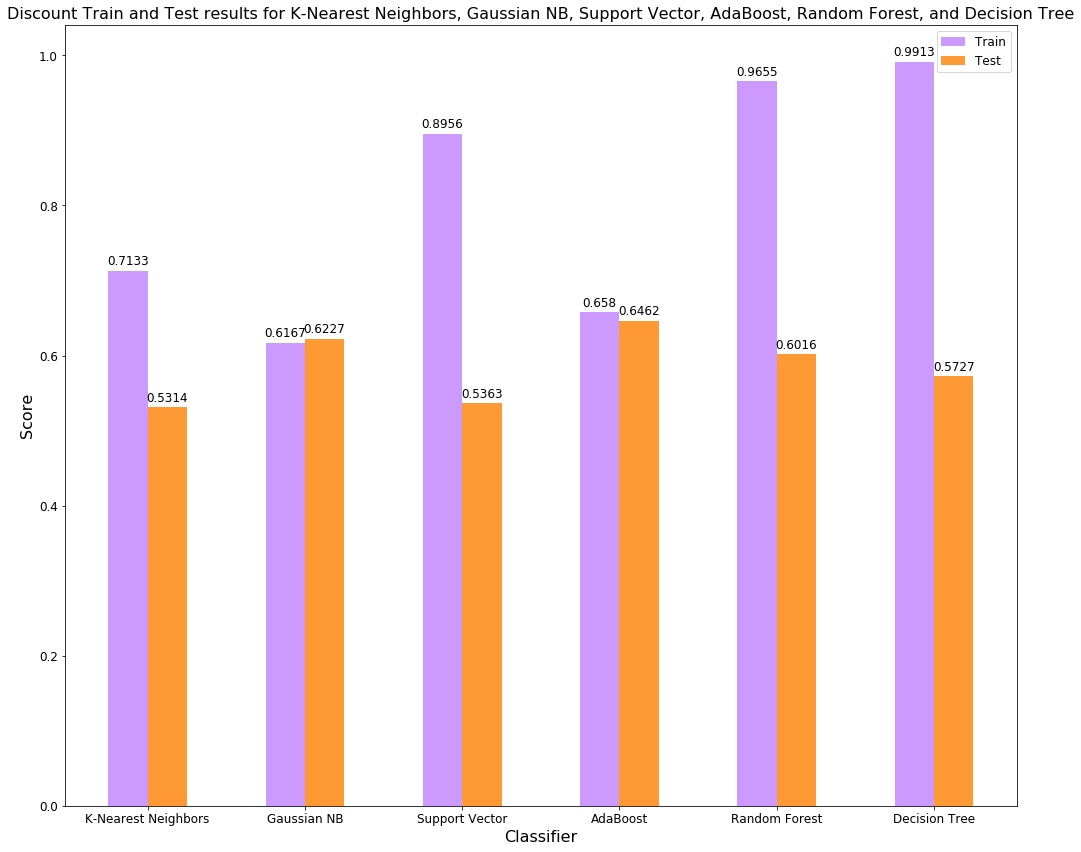

In [264]:
# This code plots the graph for the Discount classifier model values for  K-Nearest Neighbors, Gaussian NB,
# Support Vector, AdaBoost, Random Forest, and Decision Tree

x2_pos = np.arange(len(discount_classifier))
width = 0.25

fig, ax2 = plt.subplots()
discount_train_rects = ax2.bar(x2_pos - width/2, discount_data_train, width, color='#CC99FF', label='Train')
discount_test_rects = ax2.bar(x2_pos + width/2, discount_data_test, width, color='#FF9933', label='Test')

ax2.set_title('Discount Train and Test results for K-Nearest Neighbors, Gaussian NB, Support Vector, AdaBoost, Random Forest, and Decision Tree', fontsize=16)
ax2.set_ylabel('Score', fontsize=16)
ax2.set_xlabel('Classifier', fontsize=16)

ax2.set_xticks(x2_pos)
ax2.set_xticklabels(discount_classifier)
fig.set_size_inches(16.0, 12.0)
plt.rcParams.update({'font.size': 12})
ax2.legend()

# Function to generate labels on top of the bars
def gen_label(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax2.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Generate the labels
gen_label(discount_train_rects)
gen_label(discount_test_rects)

fig.tight_layout()

plt.show()

In [281]:
# Algorithm that predicts the preferred offer for the customer
# Different customers will product different results
customer = X_test[1:2]

# Using the predictions from the three classification models AdaBoost, Random Forest,
# and Decision Tree.  The predict() function is what drives this algorithm
ada_bogo_predict = ada_bogo.predict(customer.values)[0] 
ada_discount_predict = ada_discount.predict(customer.values)[0]

dtc_bogo_predict = dtc_bogo.predict(customer.values)[0] 
dtc_discount_predict = dtc_discount.predict(customer.values)[0]

rfc_bogo_predict = rfc_bogo.predict(customer.values)[0] 
rfc_discount_predict = rfc_discount.predict(customer.values)[0]


# Define the function and its properties
def best_offer(customer, offer, bogo_predict, discount_predict):

    if (bogo_predict == 0 & discount_predict == 0):
        print('Best offer:  None')
        
    if (offer == 'bogo'):
        if(bogo_predict == 0):
            if(discount_predict == 1):
                print('Best offer:  Preferred Discount')           
        else:
                print('Best offer:  BOGO')
    if (offer == 'discount'):
        if(discount_predict == 0):
            if(bogo_predict == 1):
                print('Best offer:  Preferred BOGO')           
        else:
                print('Best offer:  Discount')

In [282]:
# Customer wants BOGO; best offer gives what is predicted using AdaBoost
best_offer(customer, 'bogo', ada_bogo_predict, ada_discount_predict)

Best offer:  None


In [283]:
# Customer wants Discount; best offer gives what is predicted using AdaBoost
best_offer(customer, 'discount', ada_bogo_predict, ada_discount_predict)

Best offer:  None


In [284]:
# Customer wants BOGO; best offer gives different results (this is because
# DTC scored lower in BOGO than Discount)
best_offer(customer, 'bogo', dtc_bogo_predict, dtc_discount_predict)

Best offer:  BOGO


In [285]:
# Customer wants Discount; best offer gives what is predicted using DTC
best_offer(customer, 'discount', dtc_bogo_predict, dtc_discount_predict)

Best offer:  Preferred BOGO


In [286]:
# Customer wants Discount; best offer gives what is predicted using RFC
best_offer(customer, 'bogo', rfc_bogo_predict, rfc_discount_predict)

Best offer:  BOGO


In [287]:
# Customer wants discount; best offer gives different results (this is because
# RFC actually scored lower in discount than BOGO:  0.6016 for discount,
# versus 0.6062 for BOGO... the BOGO was slightly higher by 0.0046!)
best_offer(customer, 'discount', rfc_bogo_predict, rfc_discount_predict)

Best offer:  Preferred BOGO


<H2>Summary and Conclusions</H2>

<P>In the profile dataset, the majority of Starbucks customers were male and had a higher income.  This indicates that males were more likely to respond to an offer (BOGO or Discount) than female customers.  The original profile dataset and cleaned profile dataset showed that the average age for male customers was 54 and the income was 65K.</P>

<P>For both male and female customers, BOGO was popular; however, Discount was more popular for male customers than female customers.</P>

<P>When using the transcript dataset to perform our modeling between BOGO and Discount, a variety of classifiers were used to determine which one produced the best score.  The K-Nearest Neighbors (KNN) Classifier is often thought of as a de-facto standard; however, in evaluating the model, we discovered that is not always the case.</P>

<P>If we look at the summary of the Train and Test data for BOGO:</P>

In [272]:
bogo_summary

,Model,Train F1,Test F1
0,K-Nearest Neighbors,0.5919,0.5490
1,Gaussian NB,0.5973,0.6057
2,Support Vector,0.6301,0.5511
3,AdaBoost,0.6366,0.6394
4,Random Forest,0.6582,0.6062
5,Decision Tree,0.6627,0.5695


<P>KNN produced the lowest scores for both categories.  But in determining which of the models would be best used to predict if a customer would respond to a BOGO offer, Decision Tree was highest in Train (0.6627) and AdaBoost was the highest score in Test (0.6394).</P>

<P>For the Train and Test scores in Discount, we have the following summary:</P>

In [273]:
discount_summary

,Model,Train F1,Test F1
0,K-Nearest Neighbors,0.7133,0.5314
1,Gaussian NB,0.6167,0.6227
2,Support Vector,0.8956,0.5363
3,AdaBoost,0.6580,0.6462
4,Random Forest,0.9655,0.6016
5,Decision Tree,0.9913,0.5727


<P>KNN produced an even lower score for Test, but it scored higher in Train (or at least higher than it did in BOGO, but here it was higher than Gaussian NB).  Decision Tree again scored the highest in the Train model (0.9913), and AdaBoost scored the highest in Test (0.6462).  But, the results for Decision Tree between Train and Test were very different, and it affected the results in the prediction algorithm when evaluating the classifiers.</P>

<P>In evaluating BOGO and Discount, Decision Tree is the best classifier to use as a prediction engine for Training data and AdaBoost is the best classifier for Test data.</P>

<P>When using the prediction algorithm to determine what was the best offer for the customer, we used a Test customer and three different classifiers for the Test:</P>

<UL>
    <LI>AdaBoost</LI>
    <LI>Random Forest</LI>
    <LI>Decision Tree</LI>
</UL>

<P>Based on the results, it suggests the Test customer is male.</P>

<P>AdaBoost predictions were straightforward.  If the customer wanted BOGO, the prediction was BOGO.  Similar results for Discount.  The scores for AdaBoost in both BOGO and Discount were very similar.</P>

<P>For BOGO, Decision Tree Classifier was different:  It predicted that the customer could either take the Preferred Discount or None.  This is because Decision Tree had a lower score with BOGO (0.5695) than Discount (0.5727).  So Discount works better for Decision Tree Classifier.</P>

<P>Random Forest Classifier was interesting when the customer wanted a Discount.  It predicted the customer would be better with Preferred BOGO, but the scores between BOGO and Discount were separated by a small margin (0.0046).  So it appears Random Forest Classifier is leaned toward BOGO.</P>